In [274]:
%reset

In [275]:
from sklearn.metrics import plot_confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
import numpy as np

In [276]:
df=pd.read_excel('Task2_TITANIC_DATA.xlsx')
df.head(5)

,Класс каюты,Пол,Возраст,Количество родственников на борту,Номер билета,Гражданство,Количество детей на борту,Cтоимость билета,Cпаслись или нет
0,люкс,женский,29.0000,0,3780091001,Великобритания,0,211.3375,1
1,люкс,мужской,0.9167,1,3780091002,Великобритания,2,151.5500,1
2,люкс,женский,2.0000,1,3780091003,Великобритания,2,151.5500,0
3,люкс,мужской,30.0000,1,3780091004,Великобритания,2,151.5500,0
4,люкс,женский,25.0000,1,3780091005,Великобритания,2,151.5500,0


In [277]:
df.shape


(1309, 9)

In [278]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Класс каюты                        1309 non-null   object 
 1   Пол                                1309 non-null   object 
 2   Возраст                            1309 non-null   float64
 3   Количество родственников на борту  1309 non-null   int64  
 4   Номер билета                       1309 non-null   int64  
 5   Гражданство                        1294 non-null   object 
 6   Количество детей на борту          1309 non-null   int64  
 7   Cтоимость билета                   1309 non-null   float64
 8   Cпаслись или нет                   1309 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 92.2+ KB


In [279]:
df.columns



Index(['Класс каюты', 'Пол', 'Возраст', 'Количество родственников на борту',
       'Номер билета', 'Гражданство', 'Количество детей на борту',
       'Cтоимость билета', 'Cпаслись или нет'],
      dtype='object')

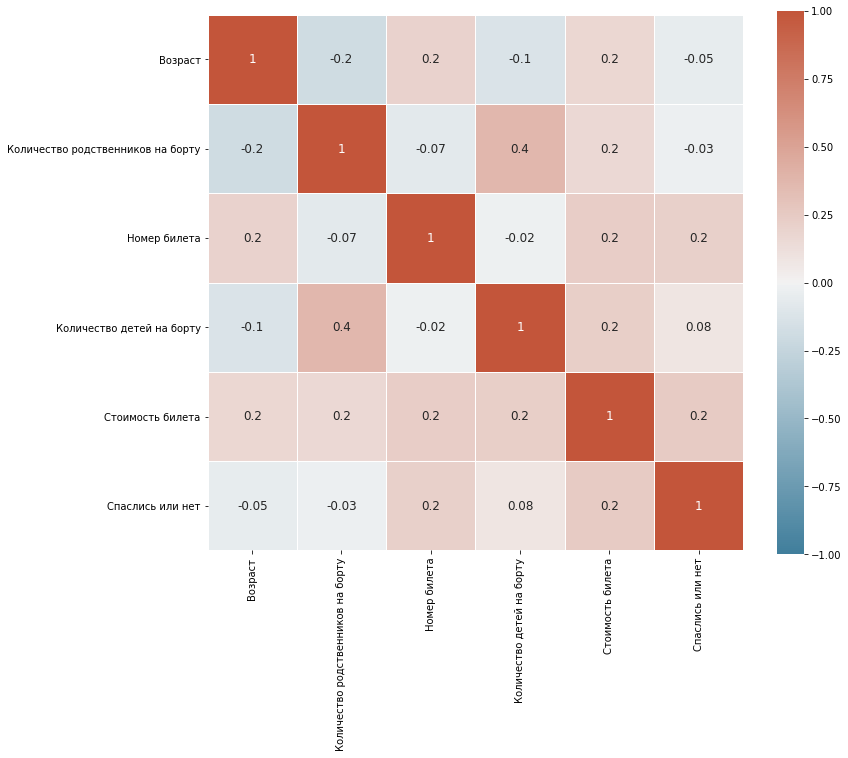

In [280]:

"Строим функцию для построения матрицы корреляции"
def plot_correlation_map(df):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    _ = sns.heatmap(
        corr,
        vmin=-1,
        vmax=1,
        cmap = cmap,
        center=0,
        robust=True,
        fmt='.1g',
        square=True,
        linewidths=.5,

        annot=True,
        annot_kws = { 'fontsize' : 12 },
        xticklabels=True,
        yticklabels=True
    )
    plt.show()
plot_correlation_map(df)

In [281]:
df.describe()


,Возраст,Количество родственников на борту,Номер билета,Количество детей на борту,Cтоимость билета,Cпаслись или нет
count,1309.000000,1309.000000,1.309000e+03,1309.000000,1309.000000,1309.000000
mean,29.881135,0.498854,2.417557e+09,0.385027,33.295479,0.381971
std,12.883199,1.041658,2.662036e+09,0.865560,51.738879,0.486055
min,0.166700,0.000000,1.389110e+08,0.000000,0.000000,0.000000
25%,22.000000,0.000000,1.389113e+08,0.000000,7.895800,0.000000
50%,29.881135,0.000000,1.389117e+08,0.000000,14.454200,0.000000
75%,35.000000,1.000000,3.780091e+09,0.000000,31.275000,1.000000
max,80.000000,8.000000,6.661099e+09,9.000000,512.329200,1.000000


In [282]:
df[['Класс каюты', 'Cпаслись или нет']].groupby(['Класс каюты'], as_index=False)\
    .mean().sort_values(by='Cпаслись или нет', ascending=False)

,Класс каюты,Cпаслись или нет
1,люкс,0.619195
0,комфорт,0.429603
2,эконом,0.255289


In [283]:
df[['Пол', 'Cпаслись или нет']].groupby(['Пол'], as_index=False)\
    .mean().sort_values(by='Cпаслись или нет', ascending=False)

,Пол,Cпаслись или нет
0,женский,0.727468
1,мужской,0.190985


In [284]:
"""Проверям на нан значения"""
df.isna().any()


Класс каюты                          False
Пол                                  False
Возраст                              False
Количество родственников на борту    False
Номер билета                         False
Гражданство                           True
Количество детей на борту            False
Cтоимость билета                     False
Cпаслись или нет                     False
dtype: bool

In [285]:
df['Гражданство'].unique()

array(['Великобритания', 'Германия', 'США', 'Франция', 'Бельгия', nan],
      dtype=object)

In [286]:
"""Удалим нан значения - так как их небольшое количество """
df['Возраст']=df['Возраст'].apply(lambda x:(round(x,0))).astype(int)

In [287]:
"""Создаем фичи по родственному признаку """
df[(df['Количество родственников на борту']==0)&
    (df['Количество детей на борту']!=0)]['Количество родственников на борту']

16      0
17      0
36      0
49      0
50      0
       ..
1230    0
1240    0
1258    0
1264    0
1265    0
Name: Количество родственников на борту, Length: 101, dtype: int64

In [288]:
df['Размер семьи на борту']=df['Количество родственников на борту']+df['Количество детей на борту']+1
df['Одиночка']=df['Размер семьи на борту'].apply(lambda x: 1 if x==1 else 0)
df['Классификация семьи']=df['Размер семьи на борту'].apply(lambda x: 0 if x == 1 else 1 if x < 3 else 2 if x < 5 else 3)

df[['Одиночка','Размер семьи на борту','Классификация семьи']]

,Одиночка,Размер семьи на борту,Классификация семьи
0,1,1,0
1,0,4,2
2,0,4,2
3,0,4,2
4,0,4,2
...,...,...,...
1304,0,2,1
1305,0,2,1
1306,1,1,0
1307,1,1,0


In [289]:
df['Классификация семьи'][df['Классификация семьи']>2]

111     3
112     3
113     3
114     3
115     3
       ..
1207    3
1208    3
1209    3
1210    3
1211    3
Name: Классификация семьи, Length: 82, dtype: int64

In [290]:
df['Возраст'].describe()

count    1309.000000
mean       29.896868
std        12.881579
min         0.000000
25%        22.000000
50%        30.000000
75%        35.000000
max        80.000000
Name: Возраст, dtype: float64

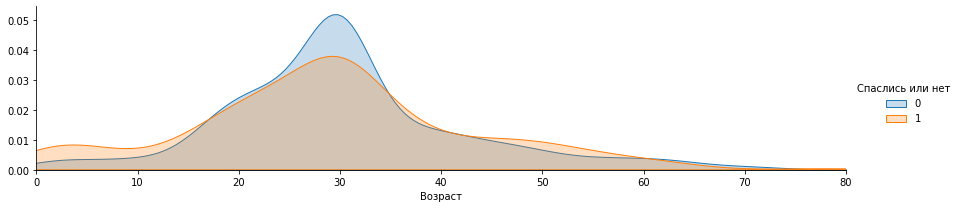

In [291]:
len(df['Возраст'][df['Возраст']<=14]),len(df['Возраст'][(df['Возраст']>14)&(df['Возраст']<=25)]),len(df['Возраст'][(df['Возраст']>25)&(df['Возраст']<=45)]),len(df['Возраст'][(df['Возраст']>45)&(df['Возраст']<=60)]),len(df['Возраст'][df['Возраст']>60])

facet = sns.FacetGrid(df,hue='Cпаслись или нет',aspect=4)
facet.map(sns.kdeplot,'Возраст',shade= True)
facet.set(xlim=(0, df['Возраст'].max()))
facet.add_legend()

In [292]:
df['Дееспособность по возрасту']=df['Возраст'].apply(
    lambda x:
    0 if x <= 8 else 1
    if (x > 8 and x<=14) else 2
    if (x > 14 and x<=18) else 3
    if (x > 18 and x<=25) else 4
    if (x > 25 and x<=30) else 5
    if (x > 30 and x<=45) else 6
    if (x > 45 and x<=60) else 7
    if (x > 60 and x<=70) else 0
)
df['Дееспособность по возрасту'][df['Дееспособность по возрасту']==4]

0       4
3       4
13      4
15      4
22      4
       ..
1303    4
1305    4
1306    4
1307    4
1308    4
Name: Дееспособность по возрасту, Length: 431, dtype: int64

<AxesSubplot:>

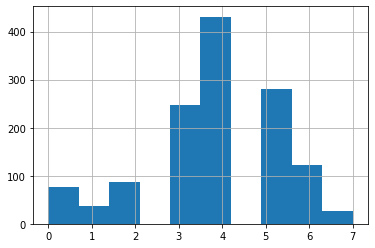

In [293]:
df['Дееспособность по возрасту'].hist()

In [294]:
df.columns



Index(['Класс каюты', 'Пол', 'Возраст', 'Количество родственников на борту',
       'Номер билета', 'Гражданство', 'Количество детей на борту',
       'Cтоимость билета', 'Cпаслись или нет', 'Размер семьи на борту',
       'Одиночка', 'Классификация семьи', 'Дееспособность по возрасту'],
      dtype='object')

In [295]:
df['Номер билета']=df['Номер билета'].apply(lambda x:str(x)[:6])

In [296]:
"""Оцениваем стоимость"""
df['Cтоимость билета'].mean()

33.29547928134553

In [297]:
df[df['Класс каюты']=='эконом']['Cтоимость билета'].describe()

count    709.000000
mean      13.331087
std       11.510752
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Cтоимость билета, dtype: float64

In [298]:
df[df['Класс каюты']=='комфорт']['Cтоимость билета'].describe()

count    277.000000
mean      21.179196
std       13.607122
min        0.000000
25%       13.000000
50%       15.045800
75%       26.000000
max       73.500000
Name: Cтоимость билета, dtype: float64

In [299]:
df[df['Класс каюты']=='люкс']['Cтоимость билета'].describe()

count    323.000000
mean      87.508992
std       80.447178
min        0.000000
25%       30.695800
50%       60.000000
75%      107.662500
max      512.329200
Name: Cтоимость билета, dtype: float64

In [300]:
df[(df['Класс каюты']=='эконом')
   &(df['Cтоимость билета']<df[df['Класс каюты']=='эконом']['Cтоимость билета'].max())]['Cтоимость билета'].describe()

count    698.000000
mean      12.445116
std        9.160928
min        0.000000
25%        7.750000
50%        8.050000
75%       14.500000
max       56.495800
Name: Cтоимость билета, dtype: float64

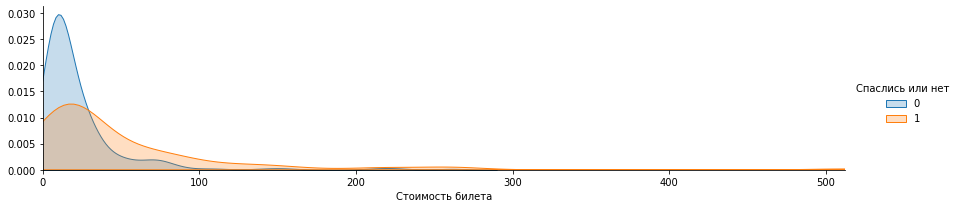

In [301]:
facet = sns.FacetGrid(df,hue='Cпаслись или нет',aspect=4)
facet.map(sns.kdeplot,'Cтоимость билета',shade= True)
facet.set(xlim=(0, df['Cтоимость билета'].max()))
facet.add_legend()

In [302]:
"""Создаем фичу с бесплатными билетами"""
df['Бесплатный билет']=df['Cтоимость билета'].apply(lambda x: 1 if x==0 else 0)




In [303]:
"""Удалим нан значения - так как их небольшое количество """
df=df.dropna()
df

,Класс каюты,Пол,Возраст,Количество родственников на борту,Номер билета,Гражданство,Количество детей на борту,Cтоимость билета,Cпаслись или нет,Размер семьи на борту,Одиночка,Классификация семьи,Дееспособность по возрасту,Бесплатный билет
0,люкс,женский,29,0,378009,Великобритания,0,211.3375,1,1,1,0,4,0
1,люкс,мужской,1,1,378009,Великобритания,2,151.5500,1,4,0,2,0,0
2,люкс,женский,2,1,378009,Великобритания,2,151.5500,0,4,0,2,0,0
3,люкс,мужской,30,1,378009,Великобритания,2,151.5500,0,4,0,2,4,0
4,люкс,женский,25,1,378009,Великобритания,2,151.5500,0,4,0,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,эконом,женский,14,1,138911,Великобритания,0,14.4542,0,2,0,1,1,0
1305,эконом,женский,30,1,138911,Великобритания,0,14.4542,0,2,0,1,4,0
1306,эконом,мужской,26,0,138911,Великобритания,0,7.2250,0,1,1,0,4,0
1307,эконом,мужской,27,0,138911,Великобритания,0,7.2250,0,1,1,0,4,0


In [304]:
"""Создаем разделение - так как признак пола мало влияет в зависимости от возраста"""
def set_person(passenger):
    sex,age = passenger
    return 'ребёнок' if age < 16 else sex
df['Пол']=df[['Пол','Возраст']].apply(set_person,axis=1)

C:\Users\karim\AppData\Local\Temp/ipykernel_3036/519370405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Пол']=df[['Пол','Возраст']].apply(set_person,axis=1)


In [305]:
"""Декодируем нечисловые признаки в числовые"""
features = df.select_dtypes('object').columns.to_list()
for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])

C:\Users\karim\AppData\Local\Temp/ipykernel_3036/3043794156.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = le.transform(df[feature])


In [306]:
"""Создаем новый признак по стоимости билета"""
df['Классификация стоимости']=df['Cтоимость билета'].apply(
    lambda x:
    0 if x <= 8 else 1
    if (x > 8 and x<=15) else 2
    if (x > 15 and x<=25) else 3
    if (x > 25 and x<=50) else 4
    if (x > 50 and x<=100) else 5
)/(df['Класс каюты']+1)
df['Классификация стоимости']=df['Классификация стоимости'].astype(int)

C:\Users\karim\AppData\Local\Temp/ipykernel_3036/2692723984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Классификация стоимости']=df['Cтоимость билета'].apply(
C:\Users\karim\AppData\Local\Temp/ipykernel_3036/2692723984.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Классификация стоимости']=df['Классификация стоимости'].astype(int)


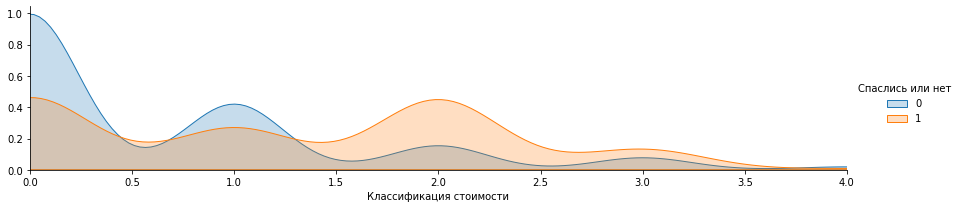

In [307]:
facet = sns.FacetGrid(df,hue='Cпаслись или нет',aspect=4)
facet.map(sns.kdeplot,'Классификация стоимости',shade= True)
facet.set(xlim=(0, df['Классификация стоимости'].max()))
facet.add_legend()

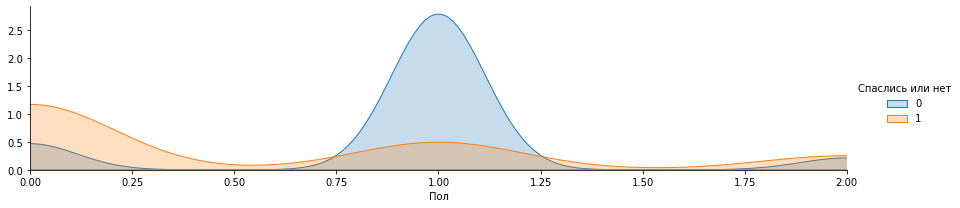

In [308]:
facet = sns.FacetGrid(df,hue='Cпаслись или нет',aspect=4)
facet.map(sns.kdeplot,'Пол',shade= True)
facet.set(xlim=(0, df['Пол'].max()))
facet.add_legend()

In [309]:
df=df.drop(columns=['Возраст','Количество родственников на борту','Количество детей на борту'])

In [336]:
"""Созадем excel из датасета """
df.to_excel("ready_df.xlsx")

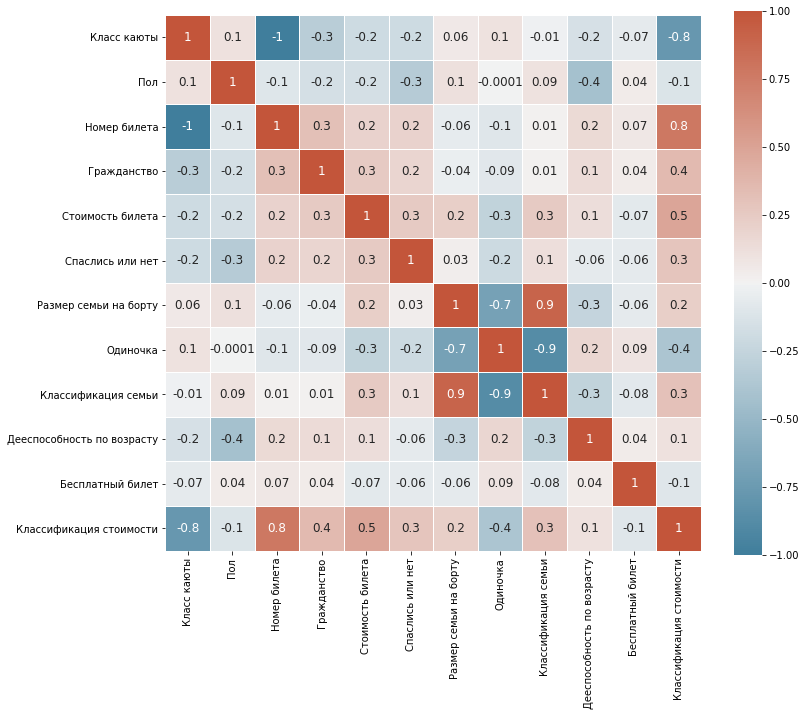

In [310]:
plot_correlation_map(df)



In [311]:
"""Моделирование"""
y=df['Cпаслись или нет']
X=df.drop(columns=['Cпаслись или нет'])

In [312]:
"""Большого разброса по количеству не наблюдается, потому будем использовать
стандартные метрики"""
y.describe()


count    1294.000000
mean        0.380989
std         0.485818
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Cпаслись или нет, dtype: float64

In [313]:
X_train,X_test,y_train,y_test =train_test_split(X.values,y.values,test_size=0.3)

In [314]:
"""Строи функции по оценке моделей"""
def test_val(model,n_splits:int=10,X:np.array=X_train,y:np.array=y_train)->None:
    scores=[]
    kfold=StratifiedKFold(n_splits=n_splits).split(X,y)
    for k,(train,test) in enumerate(kfold):
        model.fit(X[train],y[train])
        scor=model.score(X[test],y[test])
        scores.append(scor)
        print(f'Блок: {k+1},Правильность:{scor}')

def plot_learn_curv(model,X_train:np.array=X_train,y_train:np.array=y_train,cv:int=10)->None:
    train_sizes, train_scores, test_scores =\
    learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=np.linspace(0.1,1,10),
            cv=cv,
            n_jobs=-1
        )
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np. std (test_scores, axis=1)
    plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='Правильность при обучении')
    plt.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha=0.15, color='blue',
    )
    plt.plot(
        train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize='0',
        label='Правильность при проверке'
    )
    plt.fill_between(train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15, color='green')
    plt. grid ()
    plt.xlabel ('Количество обучающих образцов')
    plt.ylabel('Правильность')
    plt.legend( loc='upper right' )
    plt.ylim( [0.7,1.03])
    plt.show()


In [315]:
"""Модель случайного леса"""
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(max_depth=5,n_estimators=500,random_state=21)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.7866323907455013

In [316]:
test_val(rf)

Блок: 1,Правильность:0.7802197802197802
Блок: 2,Правильность:0.8681318681318682
Блок: 3,Правильность:0.7582417582417582
Блок: 4,Правильность:0.8021978021978022
Блок: 5,Правильность:0.8461538461538461
Блок: 6,Правильность:0.7888888888888889
Блок: 7,Правильность:0.8333333333333334
Блок: 8,Правильность:0.8333333333333334
Блок: 9,Правильность:0.7888888888888889
Блок: 10,Правильность:0.9222222222222223


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


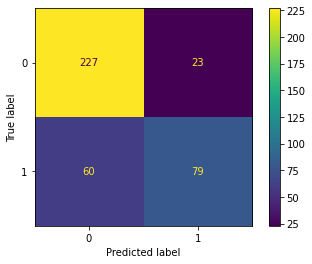

In [317]:
plot_confusion_matrix(rf,X_test,y_test)

c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


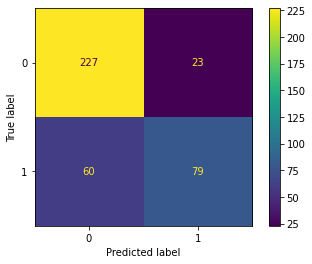

In [318]:
plot_confusion_matrix(rf,X_test,y_test)

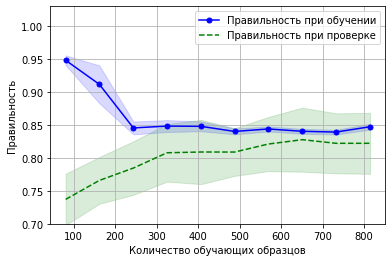

In [319]:
plot_learn_curv(rf)

In [320]:
"""Модель Бустинга Catboost """
from catboost import CatBoostClassifier
cat=CatBoostClassifier(
    max_depth=5,iterations=450, leaf_estimation_method='Gradient',
    verbose=False,)
cat.fit(X_train,y_train)
cat.score(X_test, y_test)

0.7969151670951157

In [321]:
test_val(cat)

Блок: 1,Правильность:0.7692307692307693
Блок: 2,Правильность:0.8791208791208791
Блок: 3,Правильность:0.7472527472527473
Блок: 4,Правильность:0.7802197802197802
Блок: 5,Правильность:0.8131868131868132
Блок: 6,Правильность:0.7555555555555555
Блок: 7,Правильность:0.8222222222222222
Блок: 8,Правильность:0.8333333333333334
Блок: 9,Правильность:0.8
Блок: 10,Правильность:0.9222222222222223


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


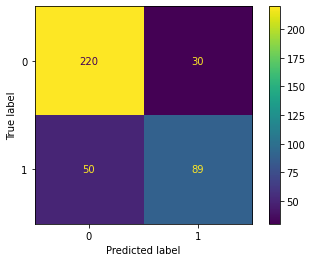

In [322]:
plot_confusion_matrix(cat,X_test,y_test)

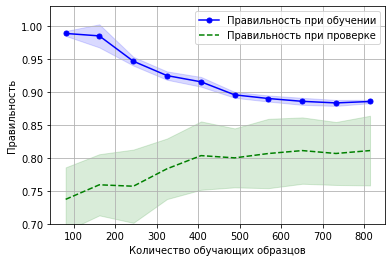

In [323]:
plot_learn_curv(cat)

In [324]:
"""Модель Бустинга xgb """
from xgboost import XGBClassifier
xgb_class=XGBClassifier(base_score=0.7,
    max_depth=5, booster='dart',n_estimators=450,objective='binary:hinge',
    learning_rate=0.4,random_state=1,reg_alpha=0.01,reg_lambda=0.4
)
xgb_class.fit(X_train,y_train)
xgb_class.score(X_test, y_test)

c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.7532133676092545

In [325]:
test_val(xgb_class)

c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.

Блок: 1,Правильность:0.7142857142857143
Блок: 2,Правильность:0.7802197802197802
Блок: 3,Правильность:0.7362637362637363
Блок: 4,Правильность:0.7912087912087912
Блок: 5,Правильность:0.8131868131868132
Блок: 6,Правильность:0.7333333333333333
Блок: 7,Правильность:0.8
Блок: 8,Правильность:0.7666666666666667
Блок: 9,Правильность:0.7555555555555555
Блок: 10,Правильность:0.8111111111111111


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


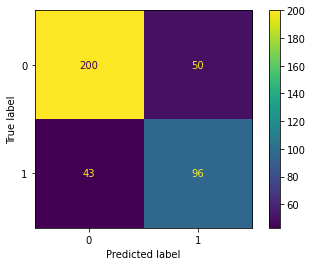

In [326]:
plot_confusion_matrix(xgb_class,X_test,y_test)

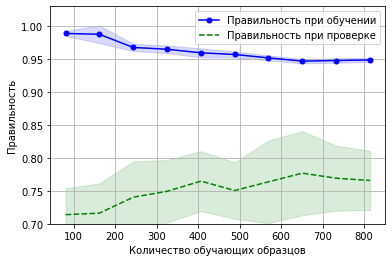

In [327]:
plot_learn_curv(xgb_class)

In [328]:
"""Создаем пайплайн для логистической регресии"""
pipe_lr=make_pipeline(
    StandardScaler(),PCA(n_components=10),LogisticRegression(max_iter=1000,solver='liblinear',class_weight='balanced',dual=True,multi_class='ovr',random_state=21)
                      )
pipe_lr.fit(X_train,y_train)
pipe_lr.score(X_test, y_test)

0.7043701799485861

In [329]:
test_val(pipe_lr)

Блок: 1,Правильность:0.7912087912087912
Блок: 2,Правильность:0.7582417582417582
Блок: 3,Правильность:0.6813186813186813
Блок: 4,Правильность:0.6593406593406593
Блок: 5,Правильность:0.7252747252747253
Блок: 6,Правильность:0.7111111111111111
Блок: 7,Правильность:0.7444444444444445
Блок: 8,Правильность:0.8111111111111111
Блок: 9,Правильность:0.8
Блок: 10,Правильность:0.7777777777777778


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


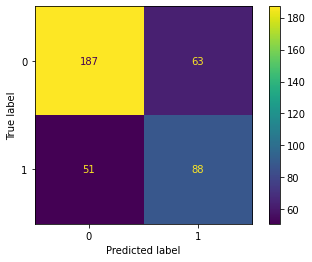

In [330]:
plot_confusion_matrix(pipe_lr,X_test,y_test)

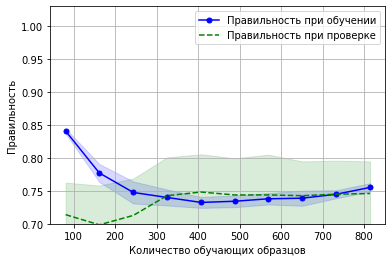

In [331]:
plot_learn_curv(pipe_lr)

In [332]:
"""Создаем ансамбль моделей"""
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
clf_labels=['Логистическая регрессия', 'Случайный лес','Catboost','XGBClassifier']
all_clf=[pipe_lr,rf,cat,xgb_class]
mv_clf=VotingClassifier(estimators=[
    ('lr', pipe_lr), ('rf', rf), ('cat', cat),('xgb_class', xgb_class)], voting='soft')
clf_labels+=['Мажоритарное голосование']
all_clf+=[mv_clf]

In [333]:
"""Проверяем их точность с кросс валидацией"""
for clf,label in zip(all_clf, clf_labels):
  scores=cross_val_score(estimator=clf,X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print(f'ROC AUC: {round(scores.mean(),2)} (+/- {round(scores.std(),2)}) [{label}]')

ROC AUC: 0.8 (+/- 0.05) [Логистическая регрессия]
ROC AUC: 0.85 (+/- 0.05) [Случайный лес]
ROC AUC: 0.87 (+/- 0.04) [Catboost]
ROC AUC: 0.75 (+/- 0.04) [XGBClassifier]
ROC AUC: 0.86 (+/- 0.04) [Мажоритарное голосование]


c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.

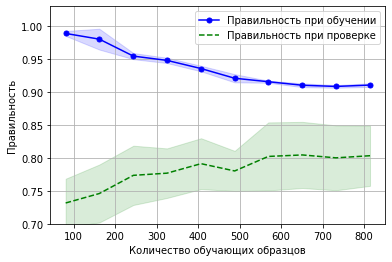

In [334]:
plot_learn_curv(mv_clf)

c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\karim\pycharmprojects\venv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


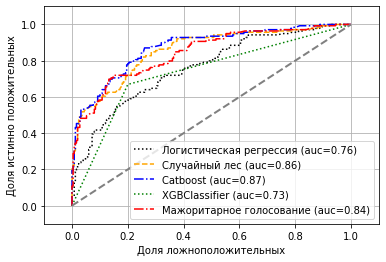

In [335]:
"""Строим roc кривую по всем моделям - выявляем лучшую"""
from sklearn.metrics import roc_curve, auc

colors=['black', 'orange','blue','green','red']
linestyles=[':','--','-.',':','-.']
for clf,label,clr,ls in zip(all_clf,clf_labels,colors, linestyles):
  y_pred=clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
  fpr,tpr,threshold=roc_curve(y_true=y_test,y_score=y_pred)
  roc_auc=auc(x=fpr,y=tpr)
  plt.plot(fpr,tpr, color=clr, linestyle=ls, label=f'{label} (auc={round(roc_auc,2)})')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle='--',color='gray',linewidth=2)

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid()
plt.xlabel('Доля ложноположительных')
plt.ylabel('Доля истинно положительных')
plt.show()


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


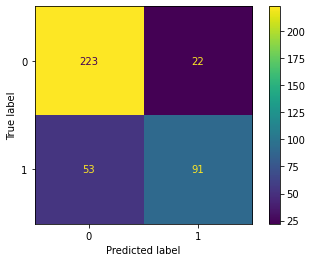

In [493]:
"""Выбираем итоговую модель Случайного леса ,
 так у нее высокая сходимость точность на тестовых и валидационных данных"""

